In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

# Load the Results

In [97]:
df = pd.read_csv('clustering_results.csv')
print(df.head())

  dataset    method  num_clusters sampling  pca      tp     fp     fn      tn  \
0    base    kmeans             5    smote  5.0  143743  54036  80772  117038   
1    base    kmeans            10    smote  5.0  137748  60031  76810  121000   
2    base    kmeans            30    smote  5.0  140742  57037  71239  126571   
3    base  kmeans++             5    smote  5.0  143778  54001  80871  116939   
4    base  kmeans++            10    smote  5.0  131962  65817  70811  126999   

       time  
0  1.232962  
1  1.747808  
2  2.893689  
3  1.052409  
4  1.809898  


drop all the rows where everything is classified as non fraud

In [98]:
df = df[(df['tn'] != 0) & (df['fn'] != 0)]

# Calculate Metrics for Evaluation

In [99]:
df['tpr'] = df['tp'] / (df['tp'] + df['fn']) # TPR (Recall)
df['fpr'] = df['fp'] / (df['fp'] + df['tn']) # FPR
df['precision'] = df['tp'] / (df['tp'] + df['fp']) # Precision
df['recall'] = df['tpr']  # Recall is the same as TPR
df['f1'] = 2 * df['tp'] / (2 * df['tp'] + df['fp'] + df['fn']) # F1 Score
df['accuracy'] = (df['tp'] + df['tn']) / (df['tp'] + df['tn'] + df['fp'] + df['fn'])  # Accuracy

In [100]:
df = df.replace(np.nan, 0)

In [101]:
print(df.head())

  dataset    method  num_clusters sampling  pca      tp     fp     fn      tn  \
0    base    kmeans             5    smote  5.0  143743  54036  80772  117038   
1    base    kmeans            10    smote  5.0  137748  60031  76810  121000   
2    base    kmeans            30    smote  5.0  140742  57037  71239  126571   
3    base  kmeans++             5    smote  5.0  143778  54001  80871  116939   
4    base  kmeans++            10    smote  5.0  131962  65817  70811  126999   

       time       tpr       fpr  precision    recall        f1  accuracy  
0  1.232962  0.640238  0.315863   0.726786  0.640238  0.680772  0.659222  
1  1.747808  0.642008  0.331606   0.696474  0.642008  0.668133  0.654083  
2  2.893689  0.663937  0.310646   0.711612  0.663937  0.686948  0.675734  
3  1.052409  0.640012  0.315906   0.726963  0.640012  0.680722  0.659060  
4  1.809898  0.650787  0.341346   0.667219  0.650787  0.658901  0.654621  


# Evaluate the Results

In [102]:
def create_cm_plot(tp, tn, fp, fn, title=None):
    cm = np.array([[tp, fp], [fn, tn]])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    if title:
        plt.title(title)

In [103]:
def cm_subplot(tp, tn, fp, fn, ax, title=None):
    cm = np.array([[tn, fp], [fn, tp]]) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax, colorbar=False)
    if title:
        ax.set_title(title)

def side_by_side_cms(tps, tns, fps, fns, titles):
    num_matrices = len(tps)
    fig, axs = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 5))

    for i in range(num_matrices):
        cm_subplot(tps[i], tns[i], fps[i], fns[i], ax=axs[i], title=titles[i])
    
    plt.tight_layout()
    plt.show()

In [104]:
def get_best_metrics(df, metrics):
    best = {}
    tps, fps, tns, fns, titles = [], [], [], [], []
    for metric in metrics:
        df = df.sort_values(metric, ascending=False)
        best[metric] = df.iloc[0]
        tps.append(best[metric]['tp'])
        fps.append(best[metric]['fp'])
        tns.append(best[metric]['tn'])
        fns.append(best[metric]['fn'])
        titles.append(f'{best[metric]["dataset"]} Best {metric} ({best[metric][metric]:.3f})')
        print(f'{metric}: {best[metric][metric]:.3f}')
        print(f"Method: {best[metric]['method']}, Sampling: {best[metric]['sampling']}, PCA: {best[metric]['pca']}")
        print()
        
    return tps, tns, fps, fns, titles

def get_avg_metrics(df, metrics):
    avg = {}
    for metric in metrics:
        avg[metric] = df[metric].mean()
        #print(f'{metric}: {avg[metric]:.3f}')
    return avg

In [105]:
def plot_metrics_subplots(metrics, labels, title):
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 4 * num_metrics), sharex=True)

    axes = axes if num_metrics > 1 else [axes] 

    for ax, (key, values) in zip(axes, metrics.items()):
        colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
        
        bars = ax.bar(labels, values, color=colors, alpha=0.8)
        ax.set_xlabel(f'{title.capitalize()}')
        ax.set_ylabel(key.capitalize())
        ax.set_ylim(0, 1)
        ax.set_title(f"{key.capitalize()} by {title}")

        for bar, value in zip(bars, values):
            ax.text(
                bar.get_x() + bar.get_width() / 2, 
                bar.get_height(),
                f"{value:.2f}",
                ha='center', va='bottom', fontsize=10, color='black'
            )

        legend_labels = [f"{label}" for label in labels]
        patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
        ax.legend(patches, legend_labels, title=f"{title}", loc='best')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()


## Results for Each Dataset

Dataset: base
f1: 0.710
Method: kmeans++, Sampling: under, PCA: 0.0

tpr: 0.697
Method: kmeans, Sampling: smote, PCA: 15.0

fpr: 0.375
Method: kmeans++, Sampling: smote, PCA: 0.0

precision: 0.805
Method: kmeans++, Sampling: ros, PCA: 15.0

recall: 0.697
Method: kmeans, Sampling: smote, PCA: 15.0

accuracy: 0.688
Method: kmeans, Sampling: under, PCA: 15.0



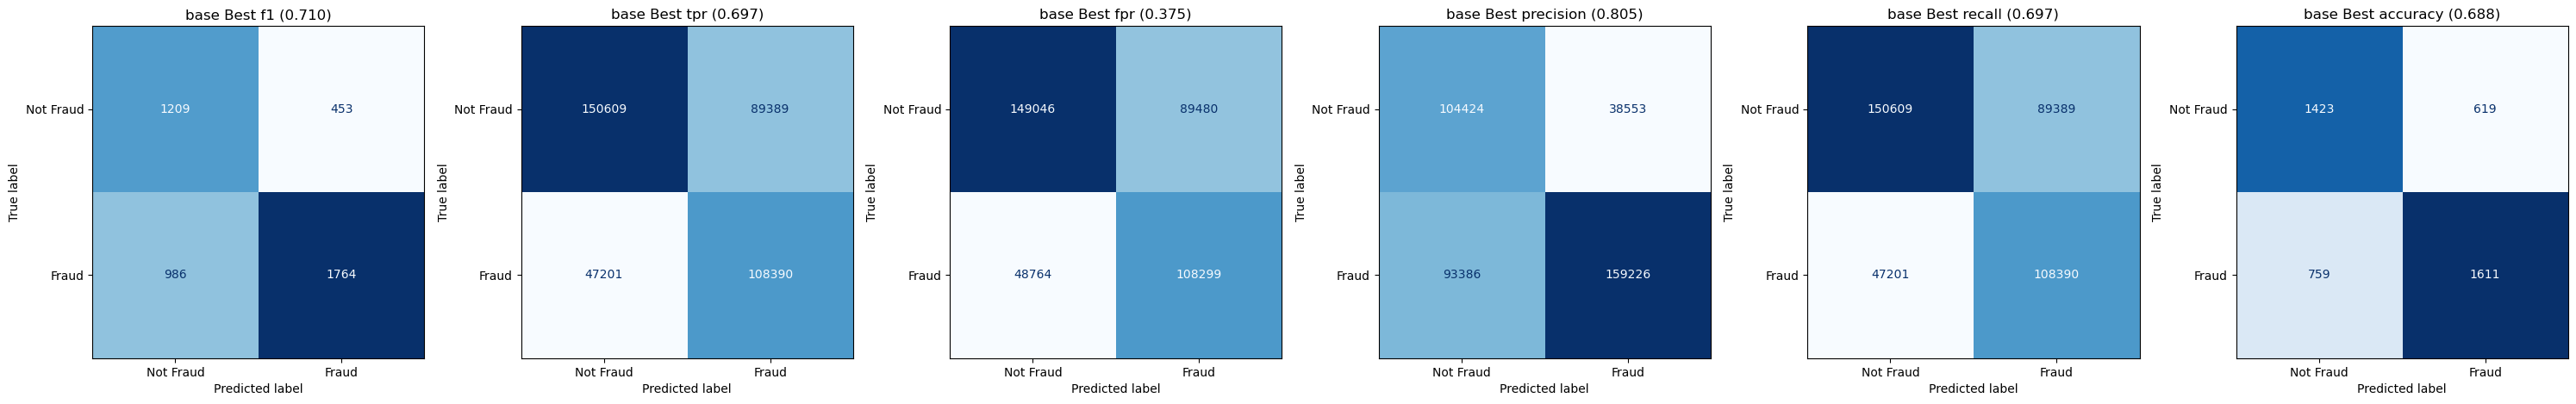

Dataset: var1
f1: 0.708
Method: kmeans++, Sampling: under, PCA: 15.0

tpr: 0.646
Method: kmeans, Sampling: under, PCA: 15.0

fpr: 0.363
Method: kmeans++, Sampling: under, PCA: 15.0

precision: 0.805
Method: kmeans, Sampling: under, PCA: 15.0

recall: 0.646
Method: kmeans, Sampling: under, PCA: 15.0

accuracy: 0.670
Method: kmeans, Sampling: under, PCA: 15.0



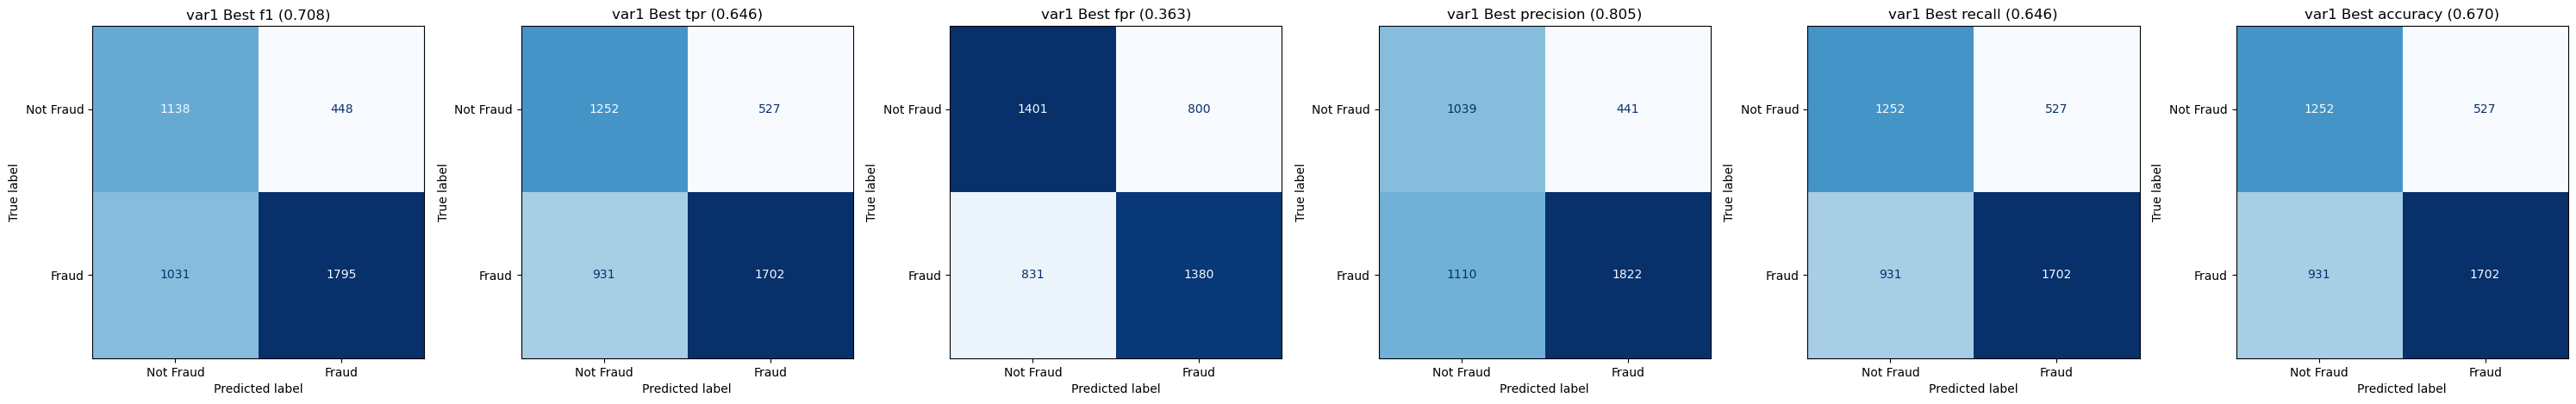

Dataset: var2
f1: 0.708
Method: kmeans++, Sampling: smote, PCA: 0.0

tpr: 0.721
Method: kmeans, Sampling: under, PCA: 5.0

fpr: 0.428
Method: kmeans++, Sampling: under, PCA: 0.0

precision: 0.805
Method: kmeans++, Sampling: smote, PCA: 0.0

recall: 0.721
Method: kmeans, Sampling: under, PCA: 5.0

accuracy: 0.692
Method: kmeans++, Sampling: smote, PCA: 0.0



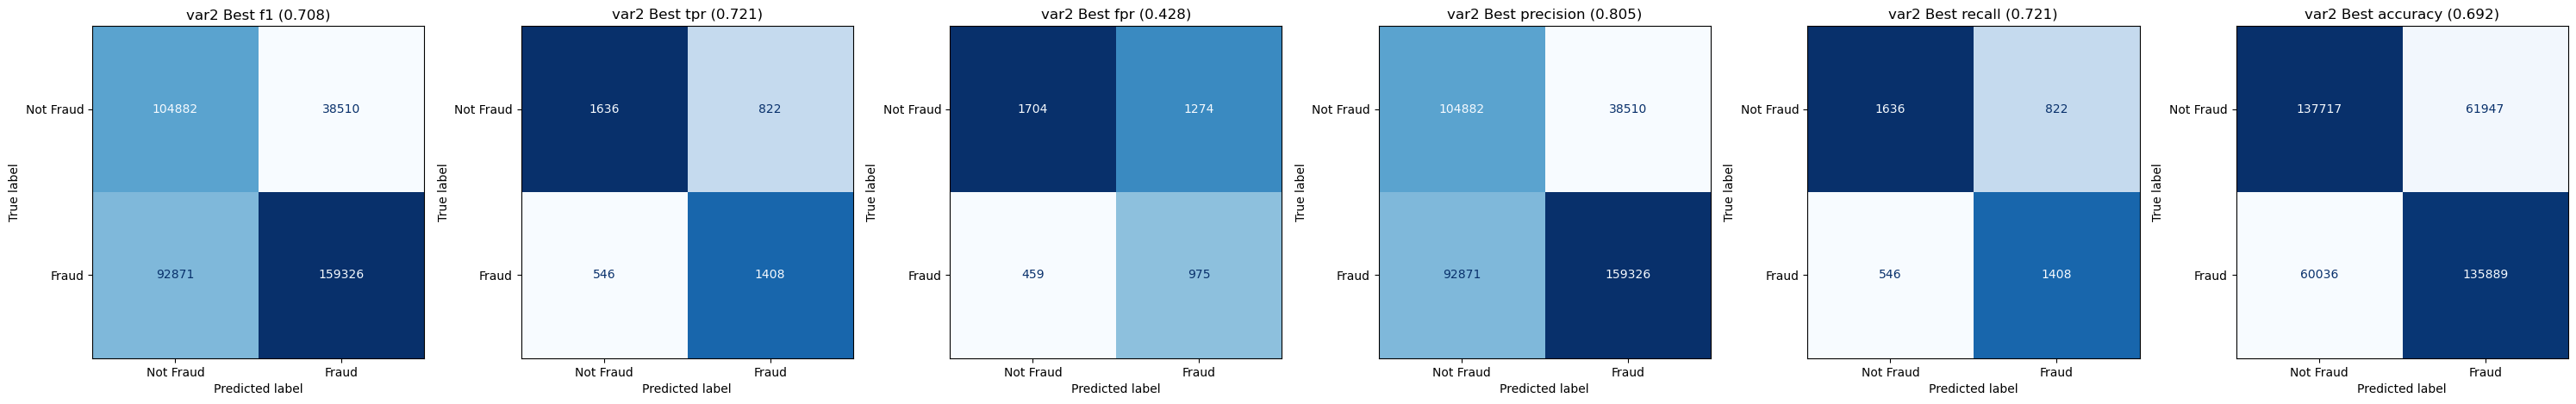

Dataset: var3
f1: 0.803
Method: kmeans, Sampling: smote, PCA: 0.0

tpr: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.364
Method: kmeans, Sampling: ros, PCA: 5.0

precision: 0.864
Method: kmeans++, Sampling: under, PCA: 15.0

recall: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.797
Method: kmeans, Sampling: smote, PCA: 0.0



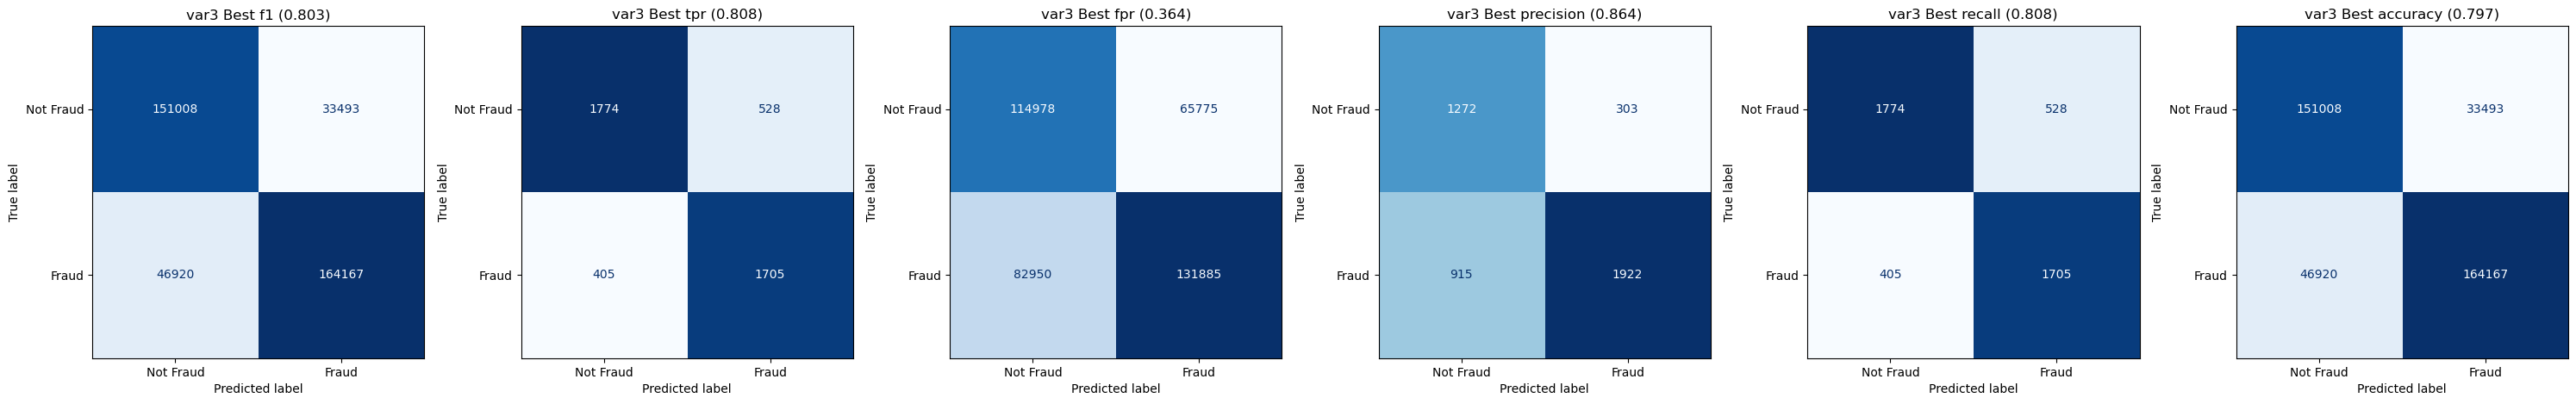

Dataset: var4
f1: 0.720
Method: kmeans, Sampling: ros, PCA: 0.0

tpr: 0.768
Method: kmeans++, Sampling: smote, PCA: 0.0

fpr: 0.351
Method: kmeans, Sampling: smote, PCA: 5.0

precision: 0.847
Method: kmeans, Sampling: smote, PCA: 15.0

recall: 0.768
Method: kmeans++, Sampling: smote, PCA: 0.0

accuracy: 0.711
Method: kmeans, Sampling: smote, PCA: 0.0



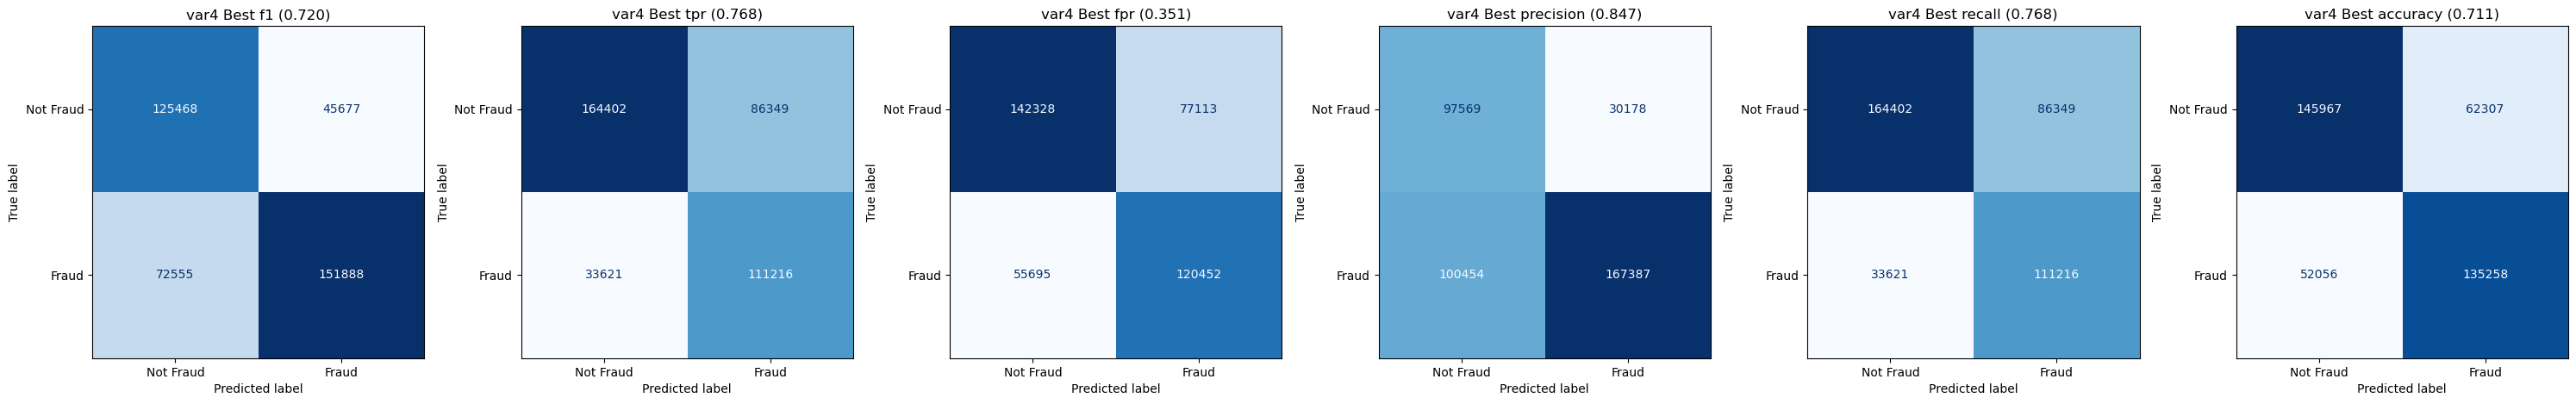

Dataset: var5
f1: 0.760
Method: kmeans, Sampling: under, PCA: 0.0

tpr: 0.745
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.389
Method: kmeans++, Sampling: under, PCA: 5.0

precision: 0.861
Method: kmeans, Sampling: smote, PCA: 0.0

recall: 0.745
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.746
Method: kmeans++, Sampling: smote, PCA: 0.0



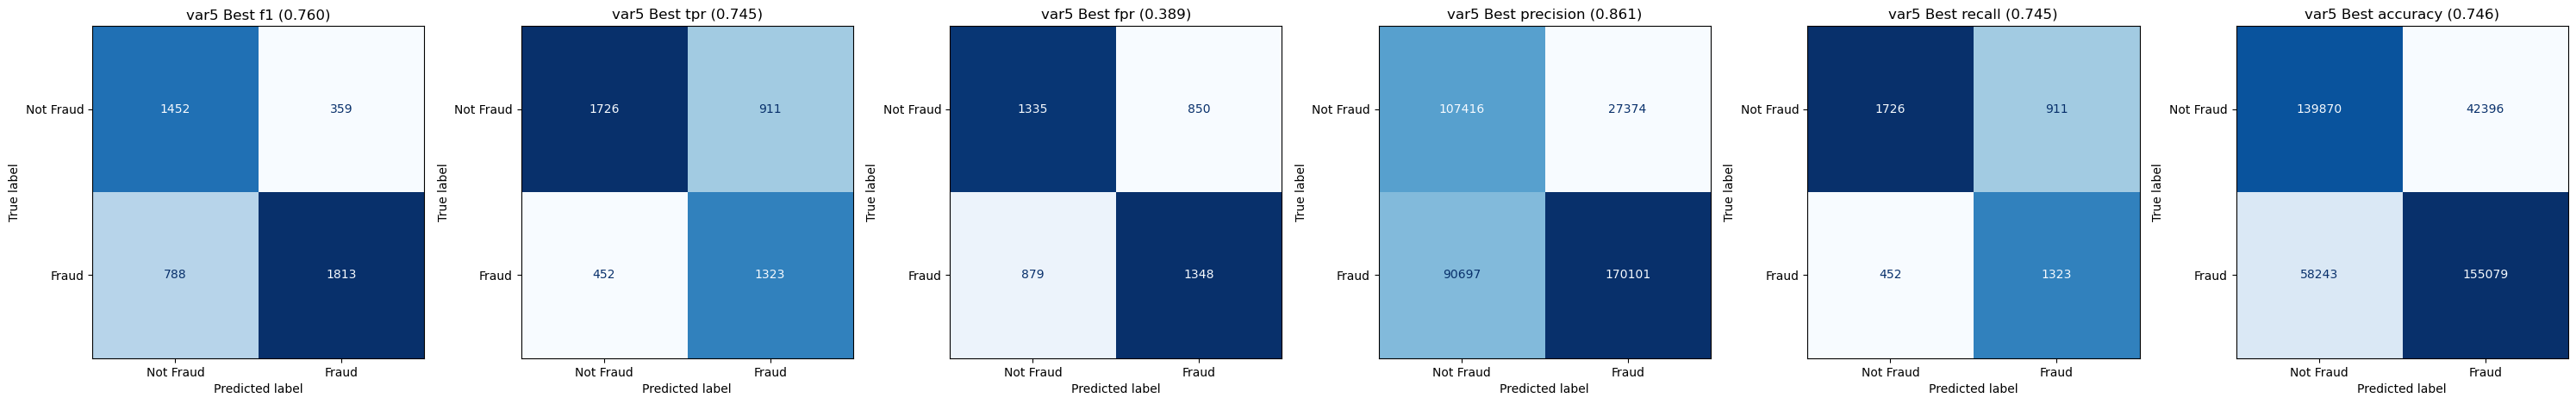

In [106]:
DATASETS = ['base', 'var1', 'var2', 'var3', 'var4', 'var5']
METRICS = ['f1', 'tpr', 'fpr', 'precision', 'recall', 'accuracy']

for dataset in DATASETS:
    curr_df = df[df["dataset"] == dataset]
    print(f"Dataset: {dataset}")
    tps, tns, fps, fns, titles = get_best_metrics(curr_df, METRICS)
    side_by_side_cms(tps, tns, fps, fns, titles)

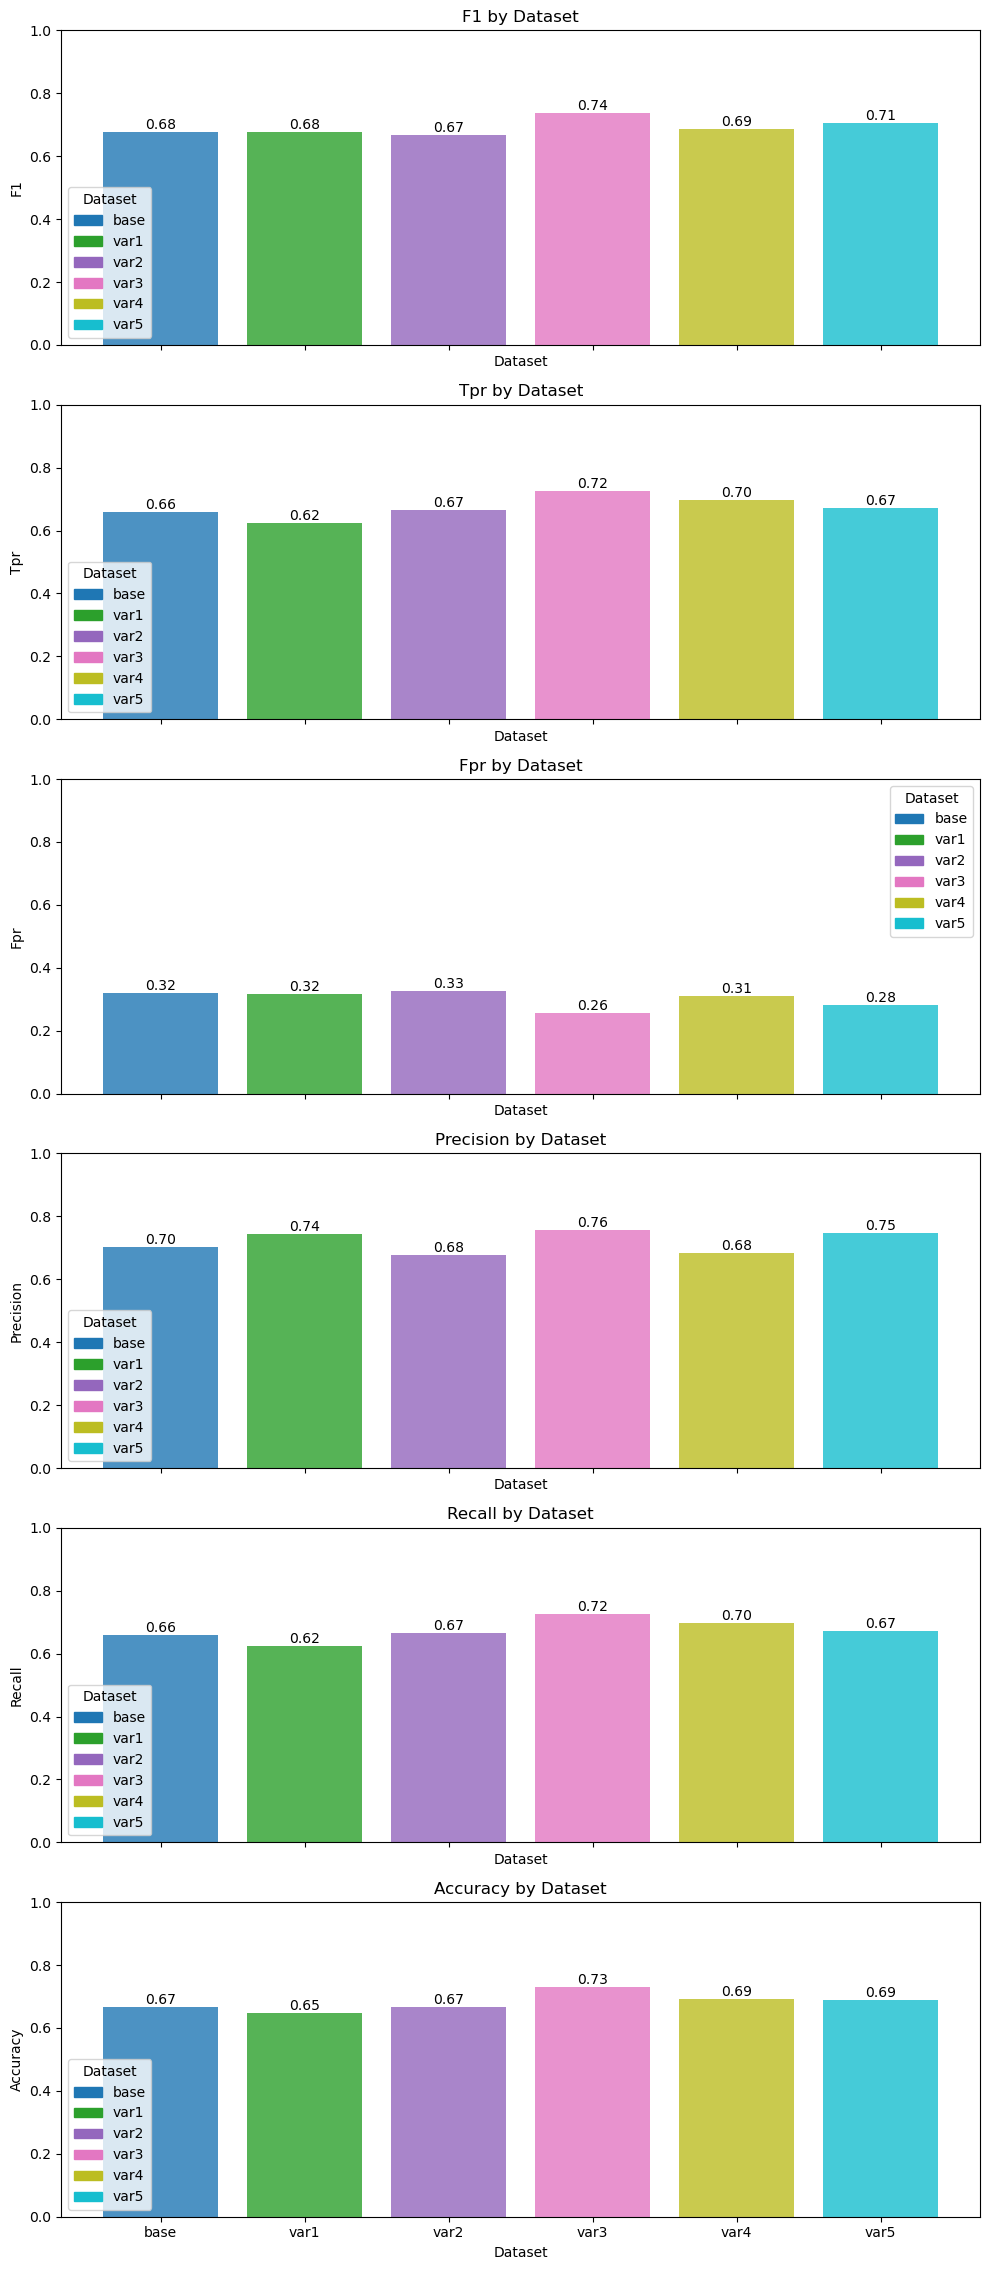

In [107]:
dataset_avg = {k: [] for k in METRICS}

for dataset in DATASETS:
    curr_df = df[df["dataset"] == dataset]
    avg = get_avg_metrics(curr_df, METRICS)
    for metric in METRICS:
        dataset_avg[metric].append(avg[metric])

plot_metrics_subplots(dataset_avg, DATASETS, 'Dataset')
        

## Results for Each Clustering Method

Method: kmeans
f1: 0.803
Method: kmeans, Sampling: smote, PCA: 0.0

tpr: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

fpr: 0.407
Method: kmeans, Sampling: under, PCA: 0.0

precision: 0.861
Method: kmeans, Sampling: smote, PCA: 0.0

recall: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

accuracy: 0.797
Method: kmeans, Sampling: smote, PCA: 0.0



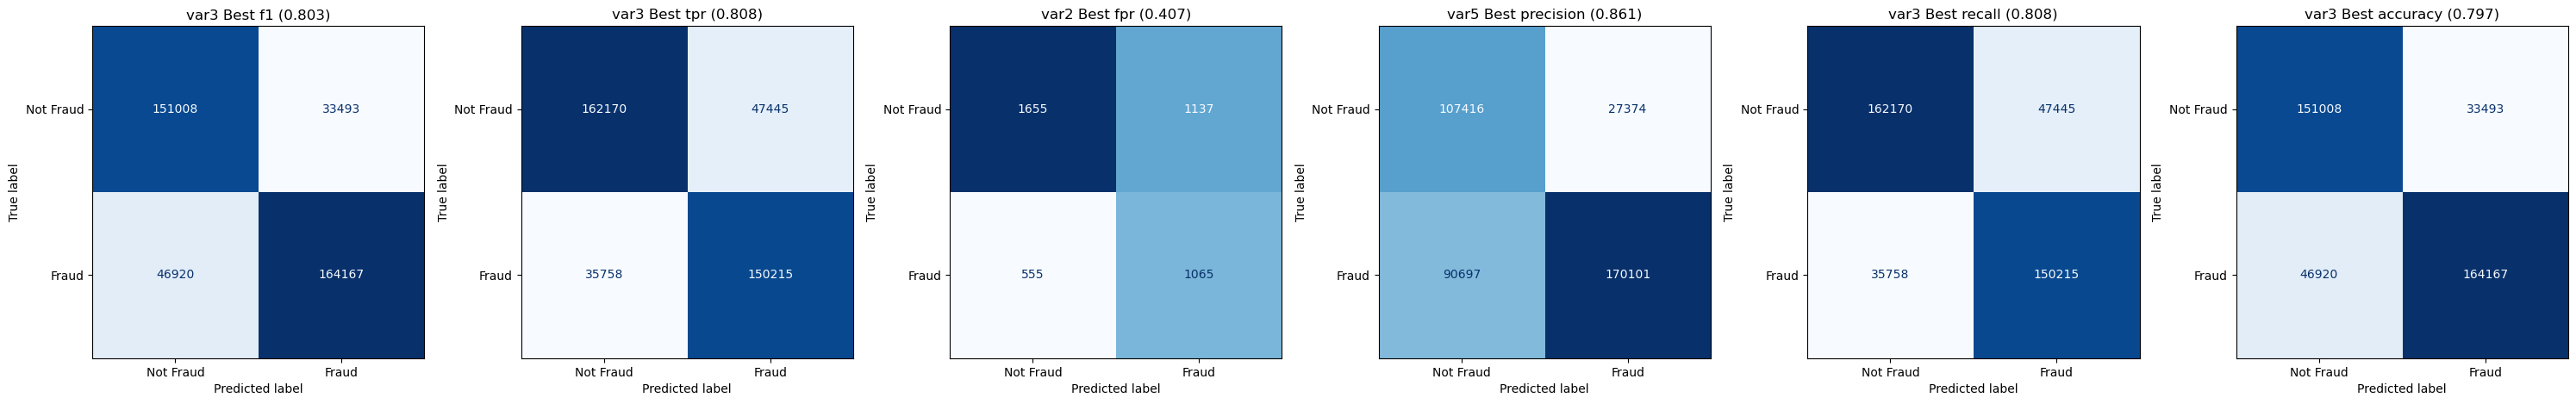

Method: kmeans++
f1: 0.786
Method: kmeans++, Sampling: ros, PCA: 0.0

tpr: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.428
Method: kmeans++, Sampling: under, PCA: 0.0

precision: 0.864
Method: kmeans++, Sampling: under, PCA: 15.0

recall: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.790
Method: kmeans++, Sampling: ros, PCA: 0.0



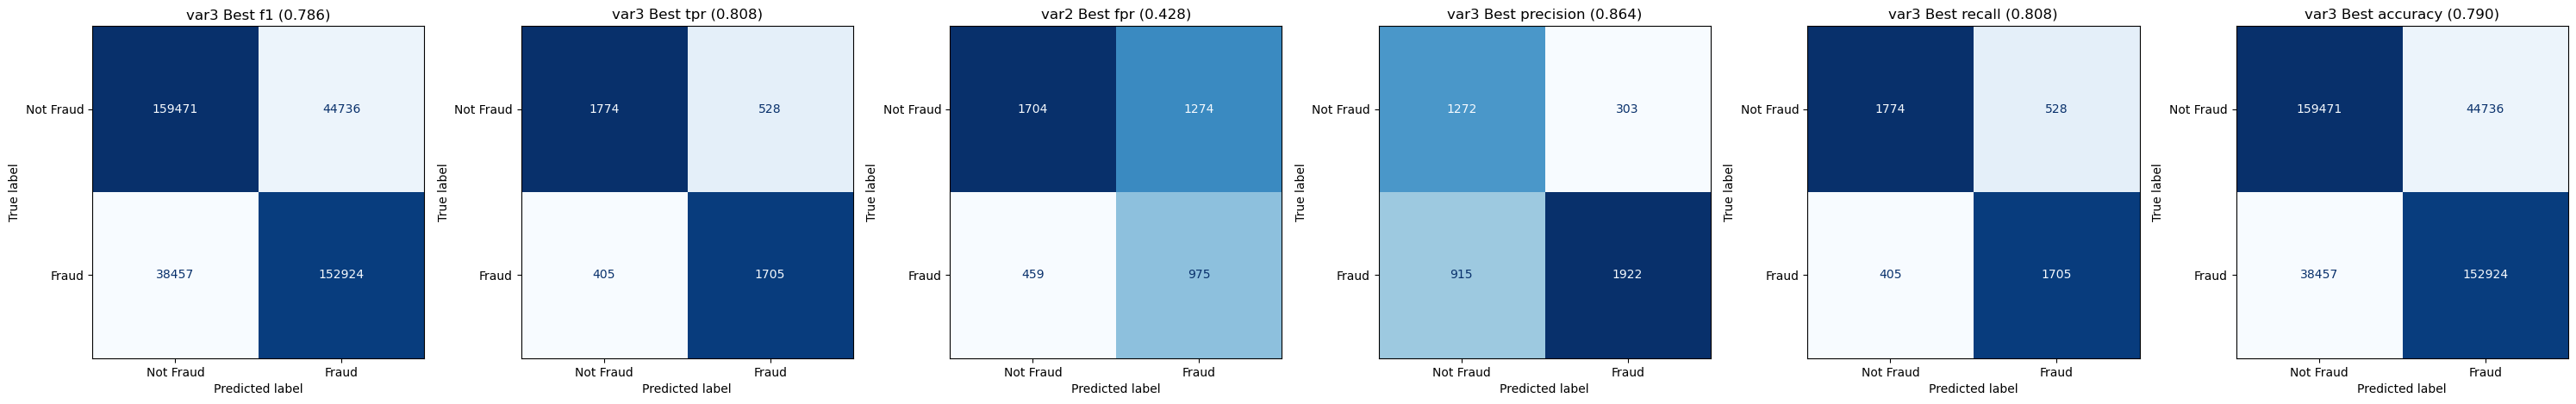

In [108]:
for method in df['method'].unique():
    curr_df = df[df['method'] == method]
    print(f"Method: {method}")
    tps, tns, fps, fns, titles = get_best_metrics(curr_df, METRICS)
    side_by_side_cms(tps, tns, fps, fns, titles)

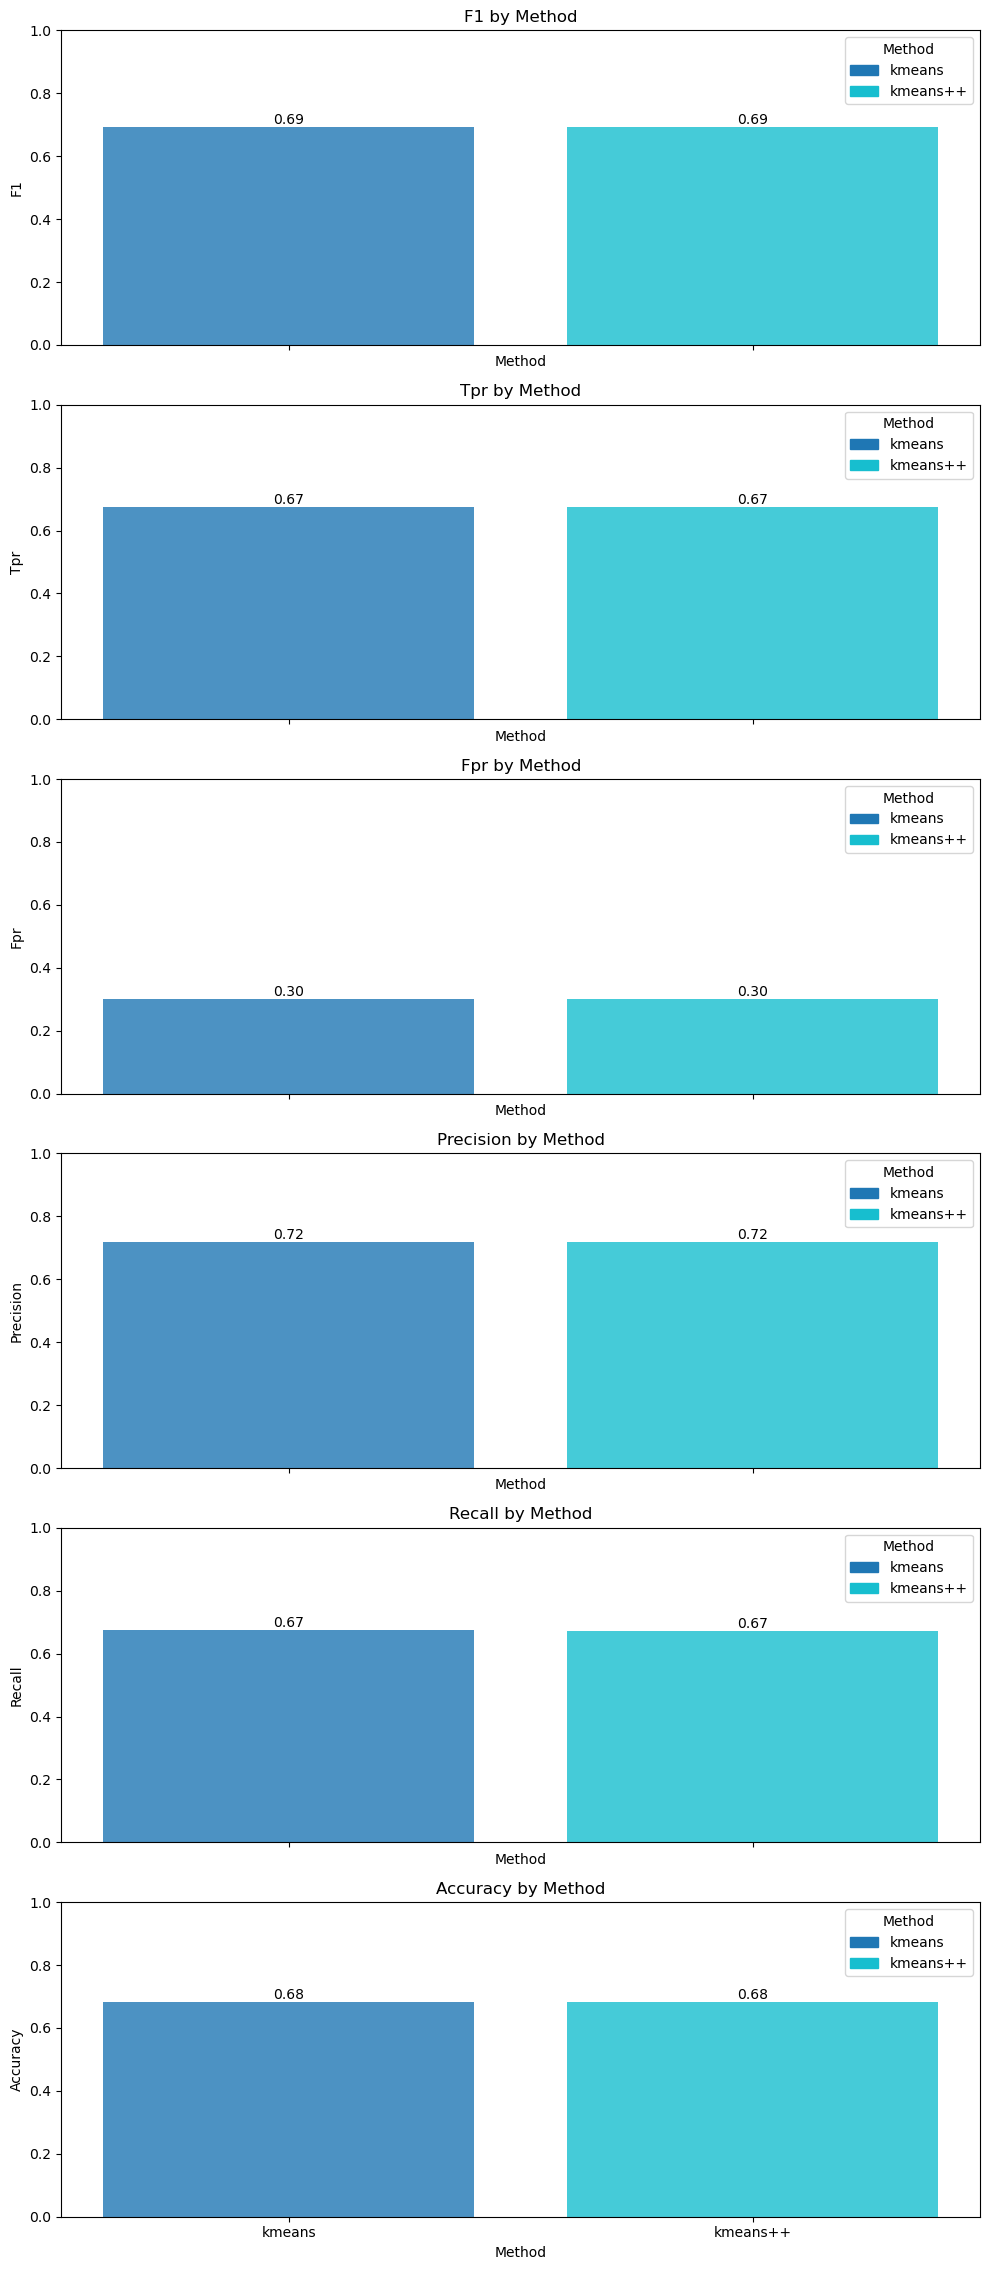

In [109]:
method_avg = {k: [] for k in METRICS}

for method in df['method'].unique():
    curr_df = df[df["method"] == method]
    avg = get_avg_metrics(curr_df, METRICS)
    for metric in METRICS:
        method_avg[metric].append(avg[metric])

plot_metrics_subplots(method_avg, df['method'].unique(), 'Method')
        

## Results for Each Sampling Method

Sampling: smote
f1: 0.803
Method: kmeans, Sampling: smote, PCA: 0.0

tpr: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

fpr: 0.386
Method: kmeans, Sampling: smote, PCA: 5.0

precision: 0.861
Method: kmeans, Sampling: smote, PCA: 0.0

recall: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

accuracy: 0.797
Method: kmeans, Sampling: smote, PCA: 0.0



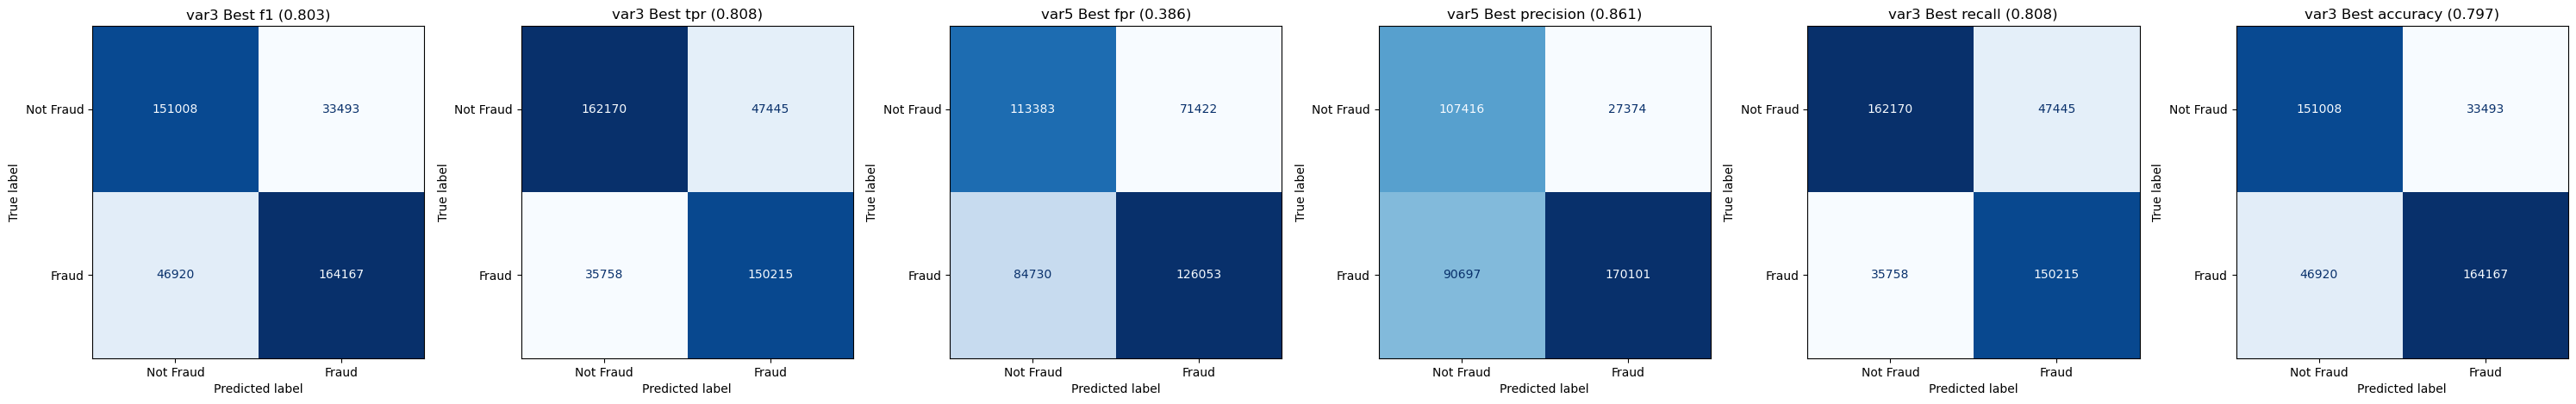

Sampling: ros
f1: 0.786
Method: kmeans++, Sampling: ros, PCA: 0.0

tpr: 0.799
Method: kmeans++, Sampling: ros, PCA: 15.0

fpr: 0.385
Method: kmeans, Sampling: ros, PCA: 5.0

precision: 0.855
Method: kmeans++, Sampling: ros, PCA: 15.0

recall: 0.799
Method: kmeans++, Sampling: ros, PCA: 15.0

accuracy: 0.790
Method: kmeans++, Sampling: ros, PCA: 0.0



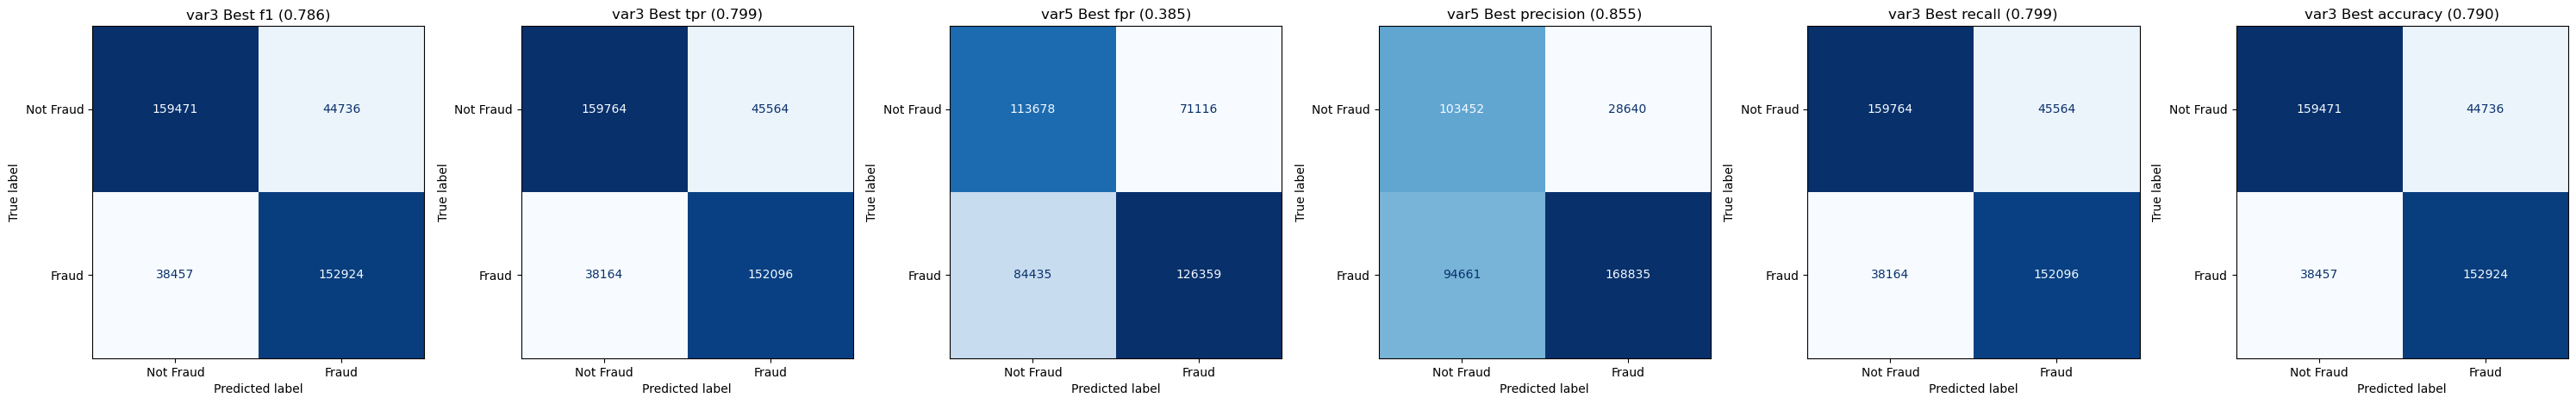

Sampling: under
f1: 0.785
Method: kmeans++, Sampling: under, PCA: 15.0

tpr: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.428
Method: kmeans++, Sampling: under, PCA: 0.0

precision: 0.864
Method: kmeans++, Sampling: under, PCA: 15.0

recall: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.789
Method: kmeans++, Sampling: under, PCA: 15.0



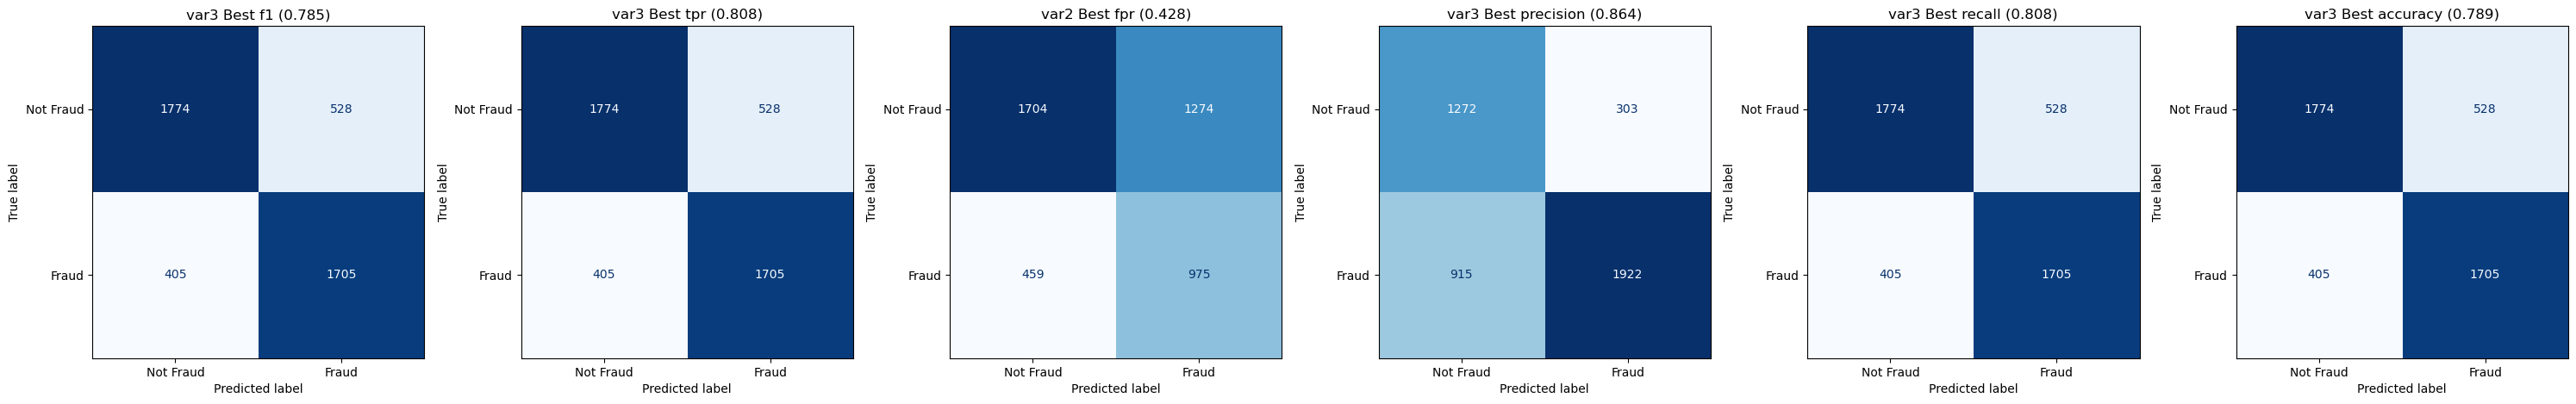

In [110]:
for sampling in df['sampling'].unique():
    curr_df = df[df['sampling'] == sampling]
    print(f"Sampling: {sampling}")
    tps, tns, fps, fns, titles = get_best_metrics(curr_df, METRICS)
    side_by_side_cms(tps, tns, fps, fns, titles)

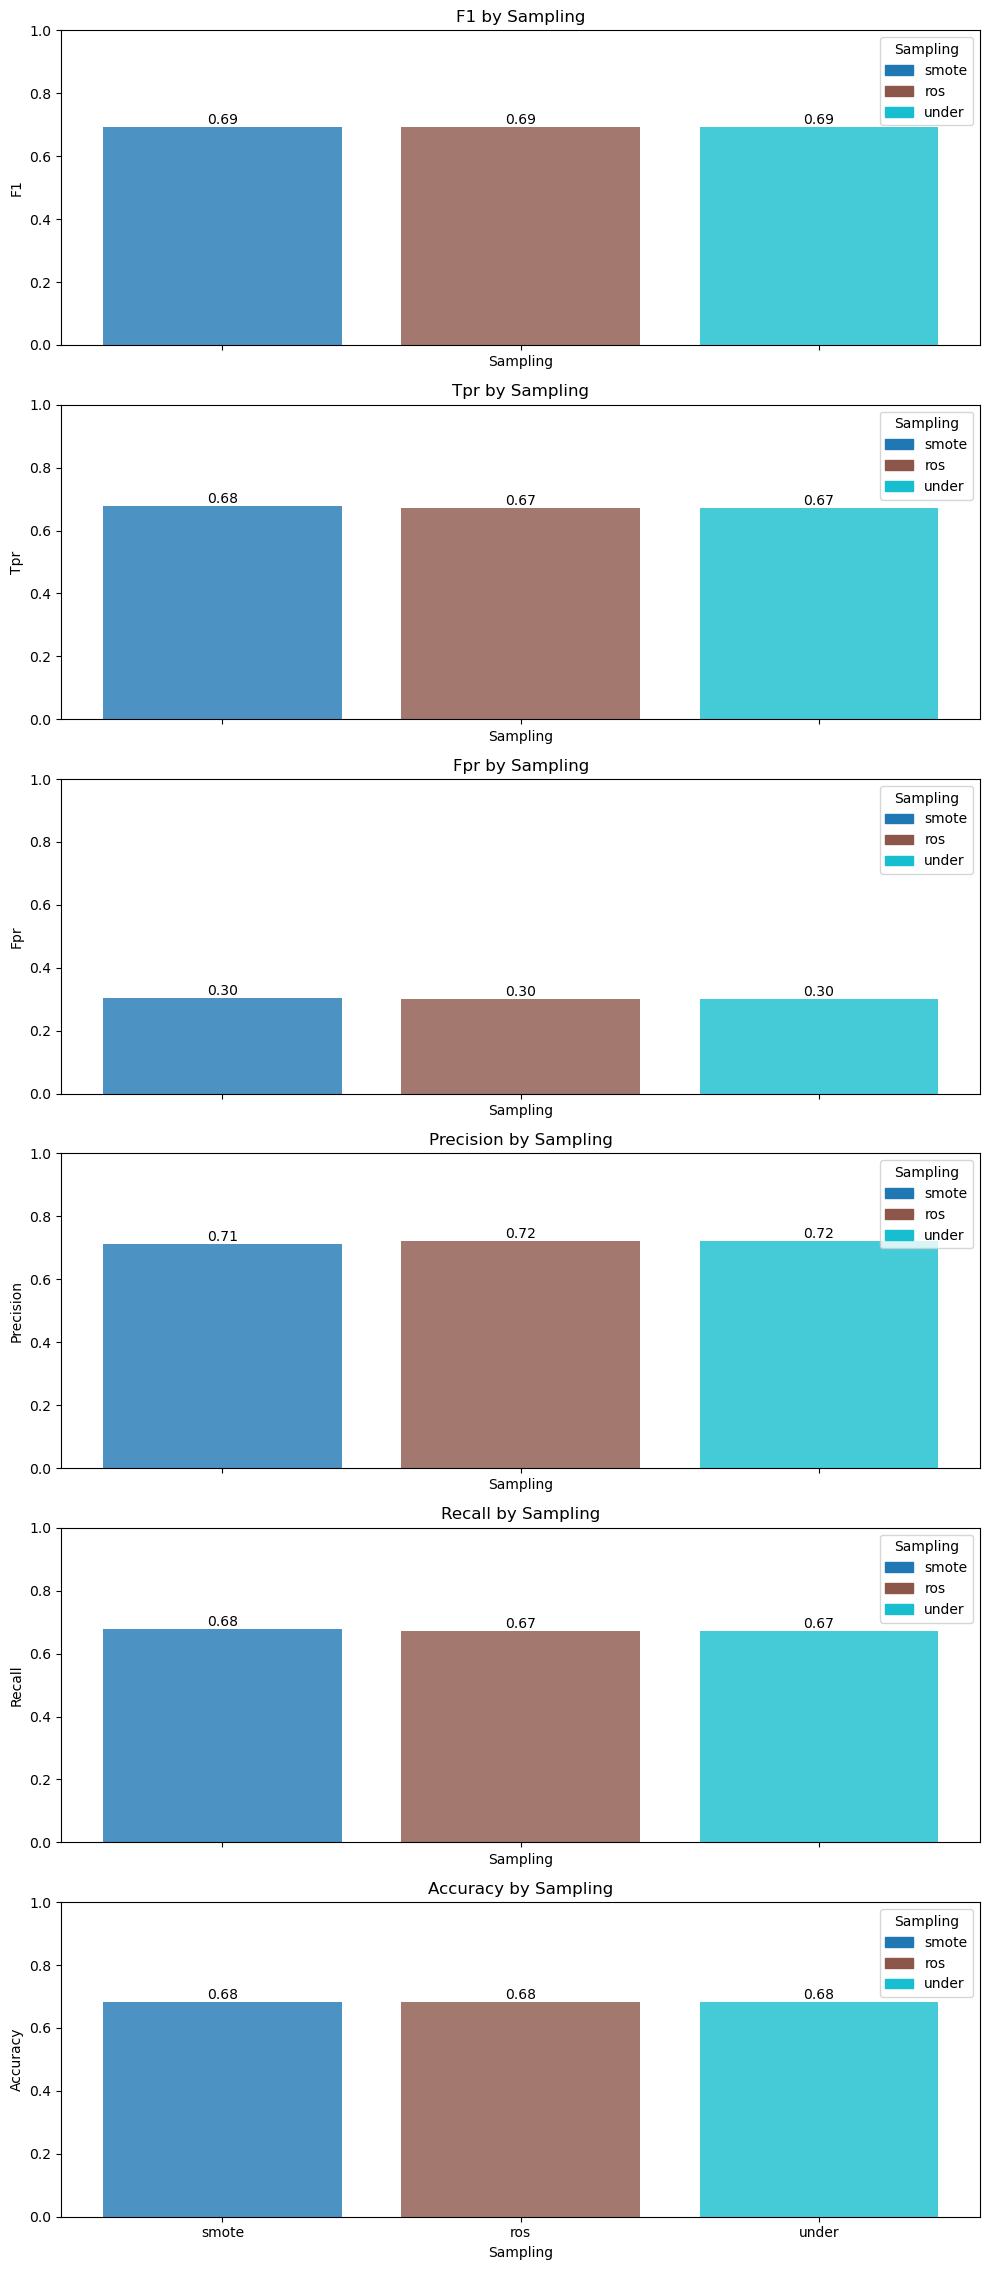

In [111]:
sample_avg = {k: [] for k in METRICS}

for sample in df['sampling'].unique():
    curr_df = df[df["sampling"] == sample]
    avg = get_avg_metrics(curr_df, METRICS)
    for metric in METRICS:
        sample_avg[metric].append(avg[metric])

plot_metrics_subplots(sample_avg, df['sampling'].unique(), 'Sampling')
        

## Results for Each PCA Size

PCA: 5.0
f1: 0.706
Method: kmeans, Sampling: under, PCA: 5.0

tpr: 0.745
Method: kmeans, Sampling: under, PCA: 5.0

fpr: 0.389
Method: kmeans++, Sampling: under, PCA: 5.0

precision: 0.804
Method: kmeans++, Sampling: ros, PCA: 5.0

recall: 0.745
Method: kmeans, Sampling: under, PCA: 5.0

accuracy: 0.701
Method: kmeans, Sampling: under, PCA: 5.0



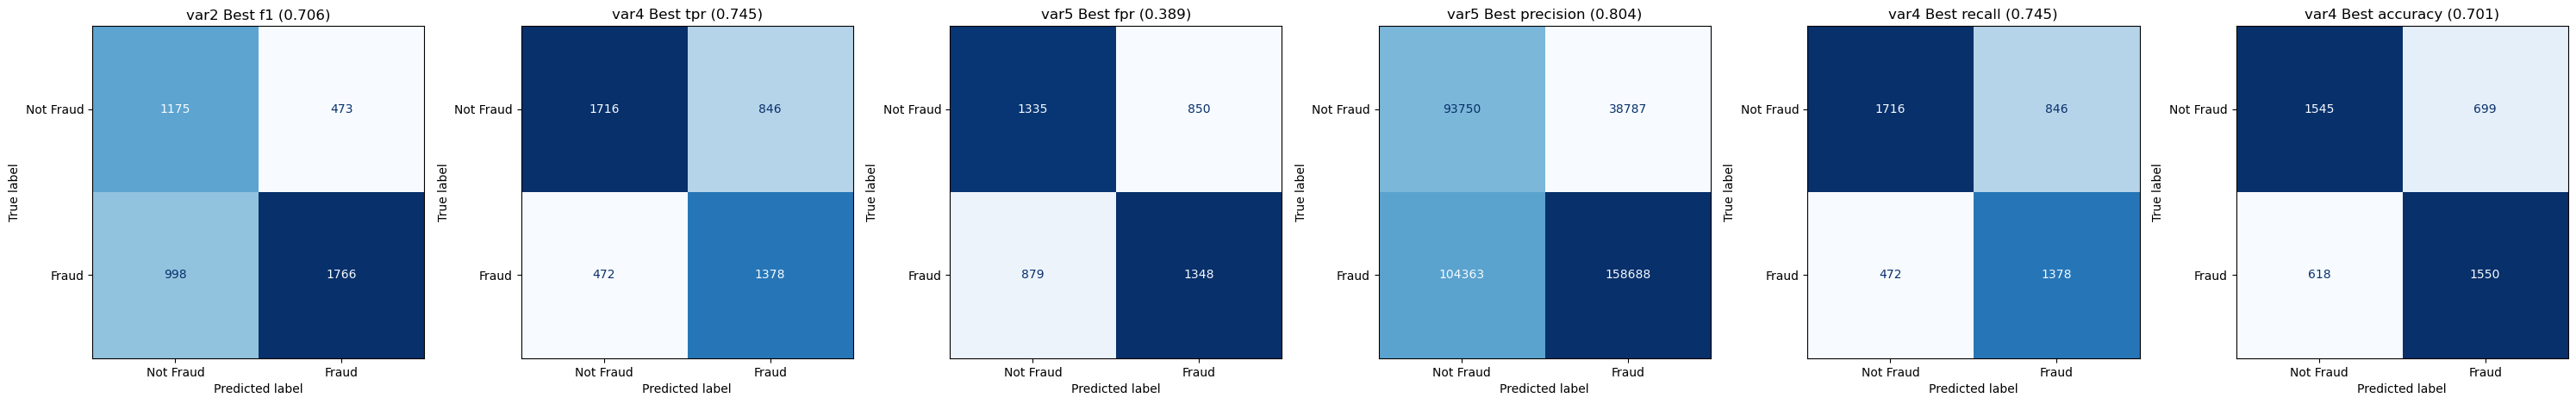

PCA: 15.0
f1: 0.785
Method: kmeans++, Sampling: under, PCA: 15.0

tpr: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.372
Method: kmeans, Sampling: smote, PCA: 15.0

precision: 0.864
Method: kmeans++, Sampling: under, PCA: 15.0

recall: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.790
Method: kmeans, Sampling: smote, PCA: 15.0



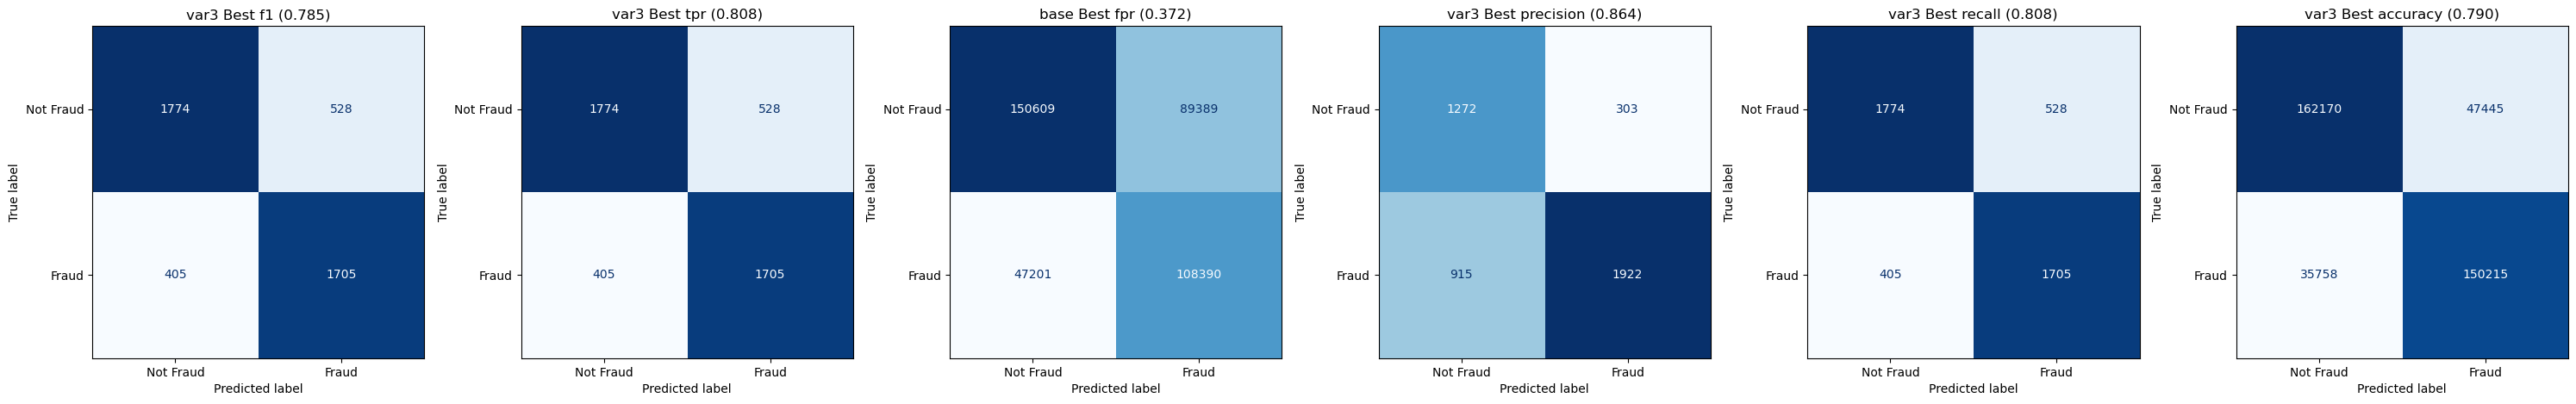

PCA: 0.0
f1: 0.803
Method: kmeans, Sampling: smote, PCA: 0.0

tpr: 0.808
Method: kmeans++, Sampling: smote, PCA: 0.0

fpr: 0.428
Method: kmeans++, Sampling: under, PCA: 0.0

precision: 0.861
Method: kmeans, Sampling: smote, PCA: 0.0

recall: 0.808
Method: kmeans++, Sampling: smote, PCA: 0.0

accuracy: 0.797
Method: kmeans, Sampling: smote, PCA: 0.0



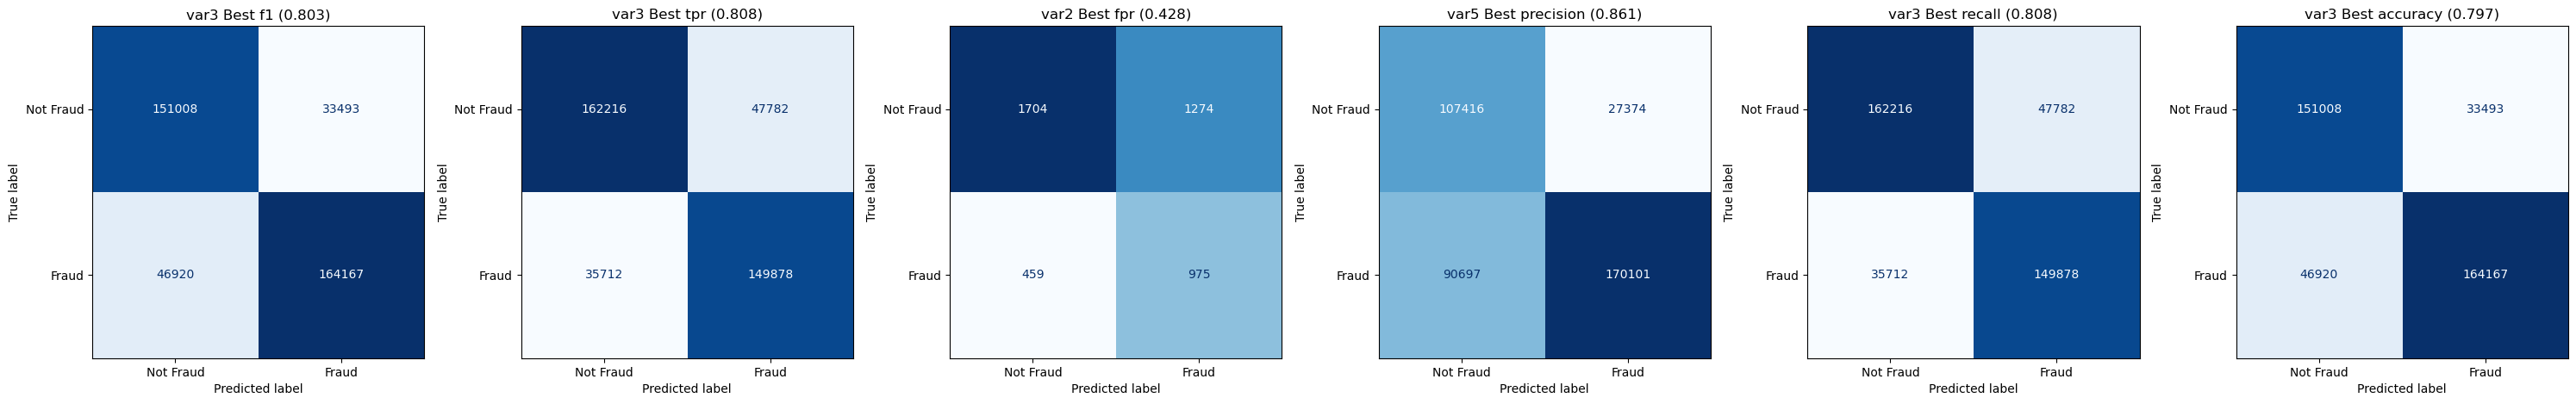

In [112]:
for pca in df['pca'].unique():
    curr_df = df[df['pca'] == pca]
    print(f"PCA: {pca}")
    tps, tns, fps, fns, titles = get_best_metrics(curr_df, METRICS)
    side_by_side_cms(tps, tns, fps, fns, titles)

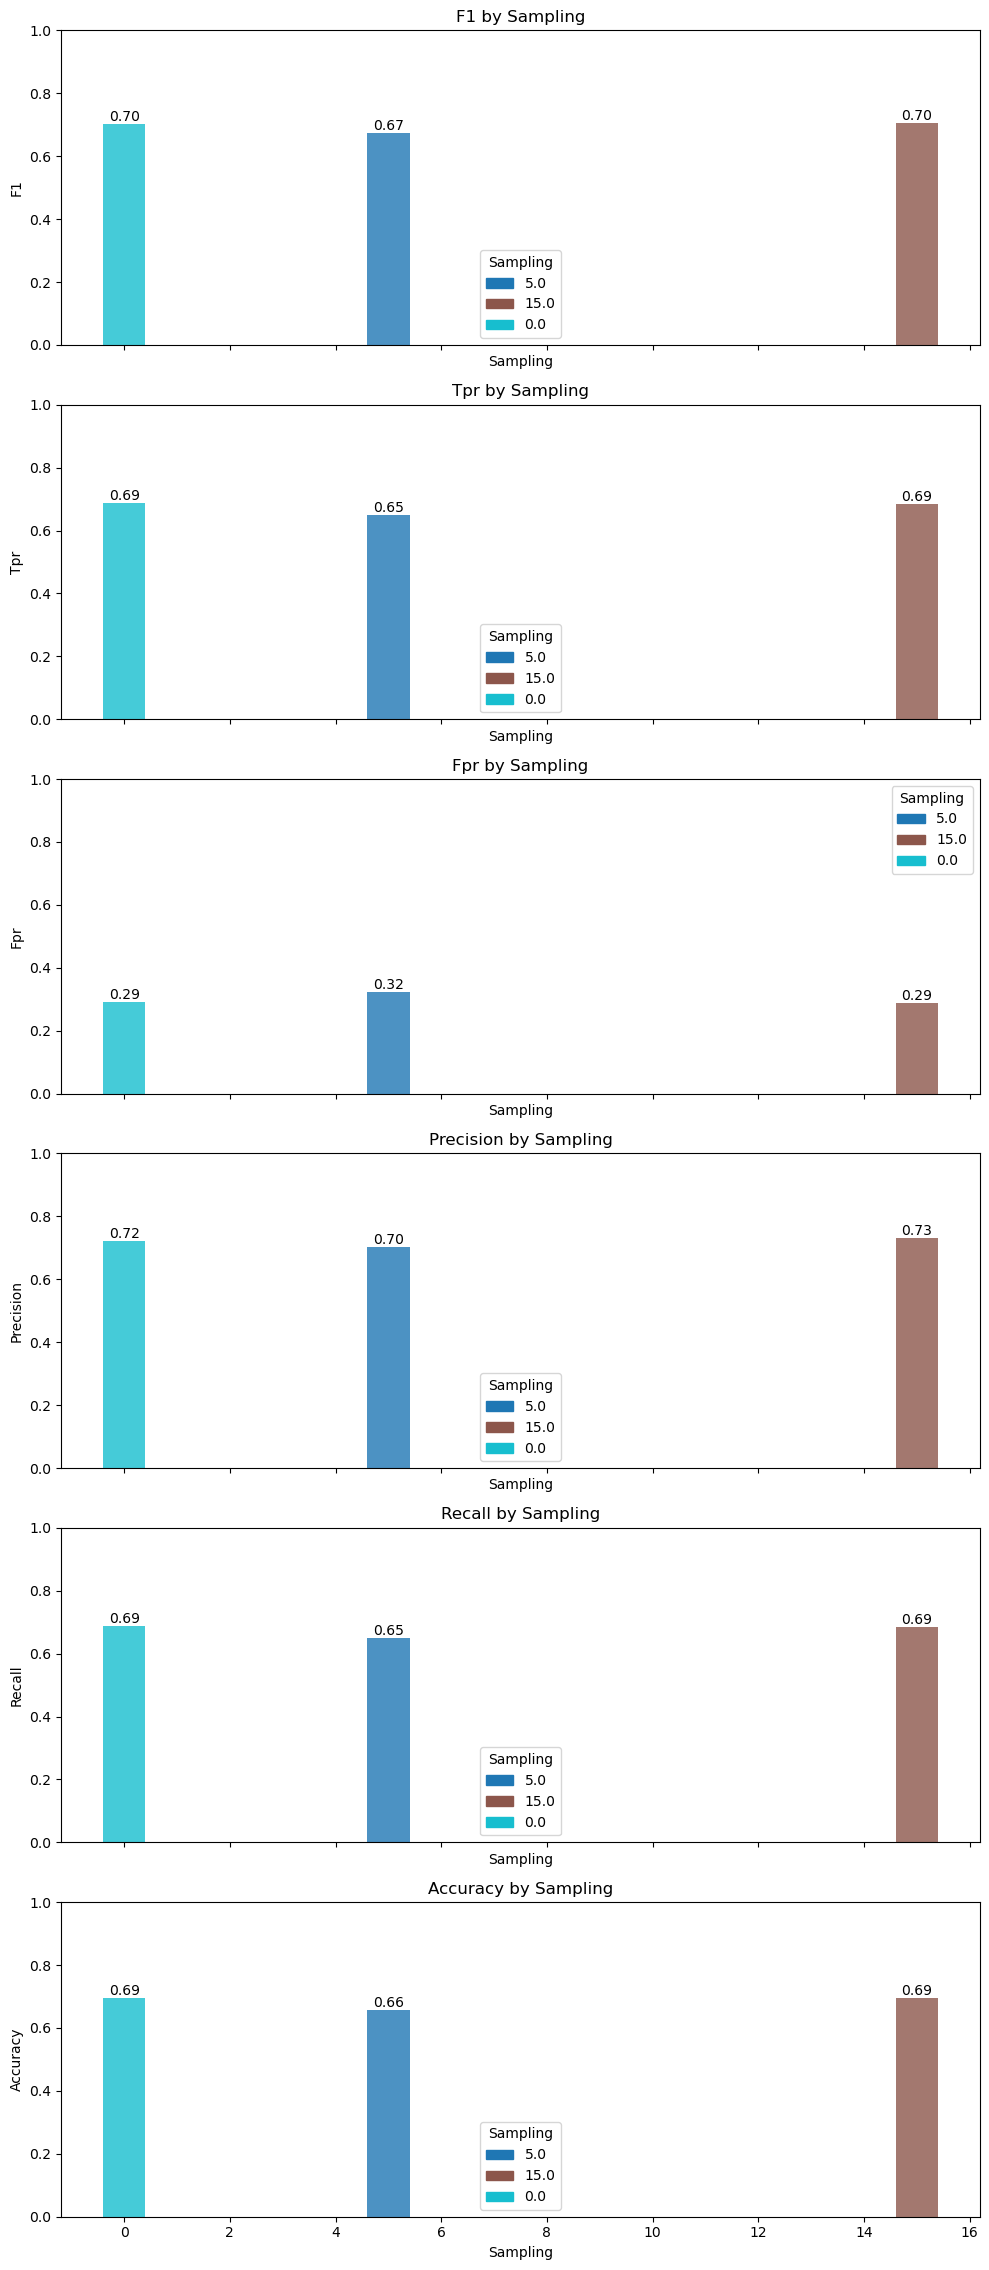

In [113]:
pca_avg = {k: [] for k in METRICS}

for pca in df['pca'].unique():
    curr_df = df[df["pca"] == pca]
    avg = get_avg_metrics(curr_df, METRICS)
    for metric in METRICS:
        pca_avg[metric].append(avg[metric])

plot_metrics_subplots(pca_avg, df['pca'].unique(), 'Sampling')
        

## Results for Each Number of Clusters

Num Cluster: 5
f1: 0.803
Method: kmeans, Sampling: smote, PCA: 0.0

tpr: 0.778
Method: kmeans, Sampling: smote, PCA: 0.0

fpr: 0.428
Method: kmeans++, Sampling: under, PCA: 0.0

precision: 0.864
Method: kmeans++, Sampling: under, PCA: 15.0

recall: 0.778
Method: kmeans, Sampling: smote, PCA: 0.0

accuracy: 0.797
Method: kmeans, Sampling: smote, PCA: 0.0



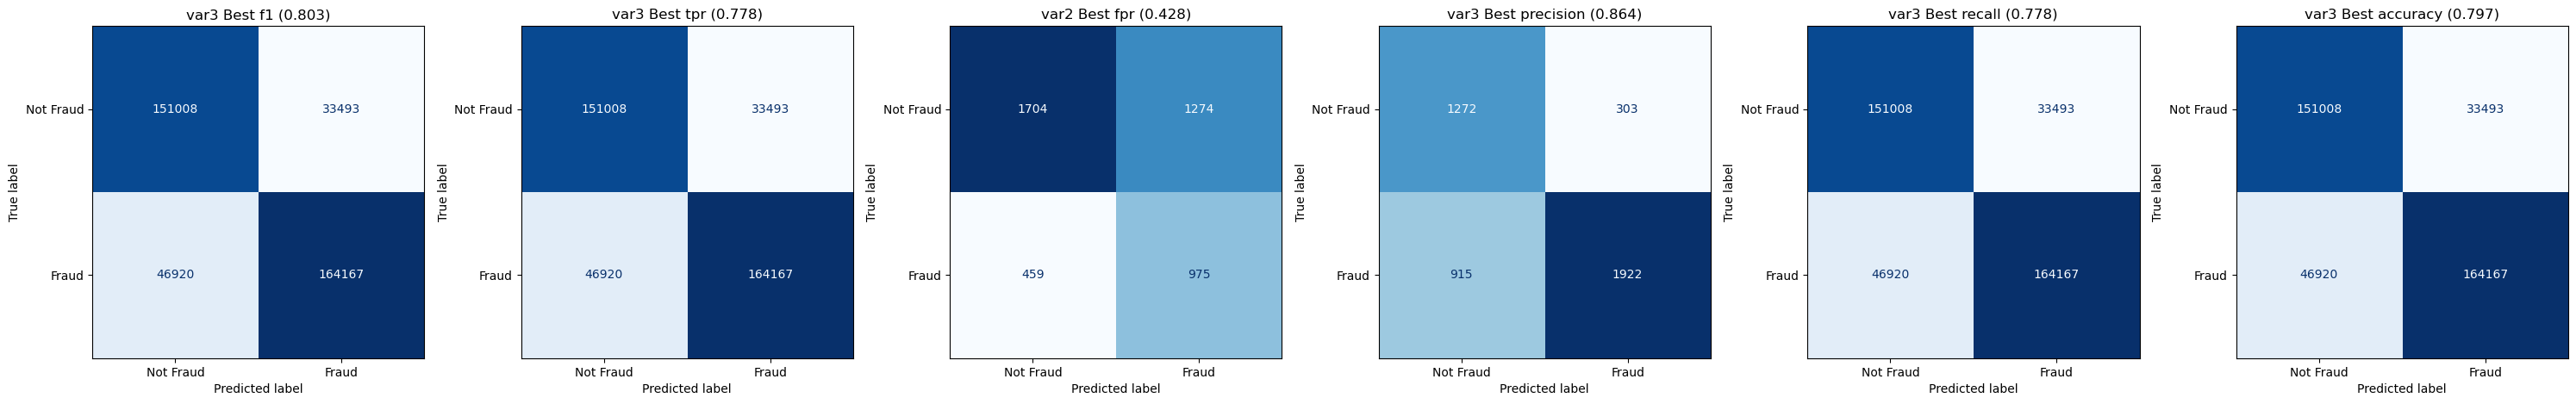

Num Cluster: 10
f1: 0.786
Method: kmeans++, Sampling: ros, PCA: 0.0

tpr: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

fpr: 0.363
Method: kmeans, Sampling: smote, PCA: 5.0

precision: 0.859
Method: kmeans, Sampling: under, PCA: 15.0

recall: 0.808
Method: kmeans++, Sampling: under, PCA: 15.0

accuracy: 0.790
Method: kmeans++, Sampling: ros, PCA: 0.0



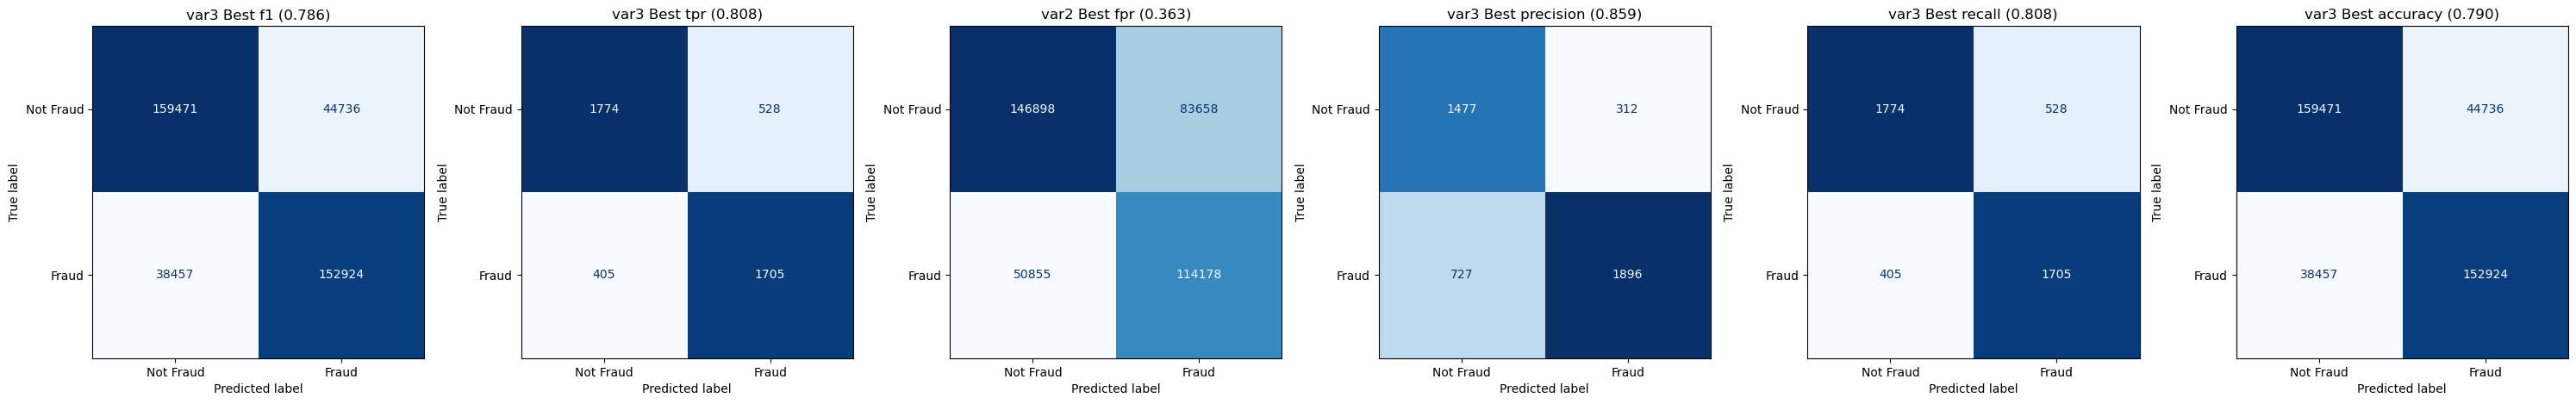

Num Cluster: 30
f1: 0.783
Method: kmeans, Sampling: smote, PCA: 15.0

tpr: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

fpr: 0.349
Method: kmeans, Sampling: smote, PCA: 5.0

precision: 0.835
Method: kmeans, Sampling: under, PCA: 0.0

recall: 0.808
Method: kmeans, Sampling: smote, PCA: 15.0

accuracy: 0.790
Method: kmeans, Sampling: smote, PCA: 15.0



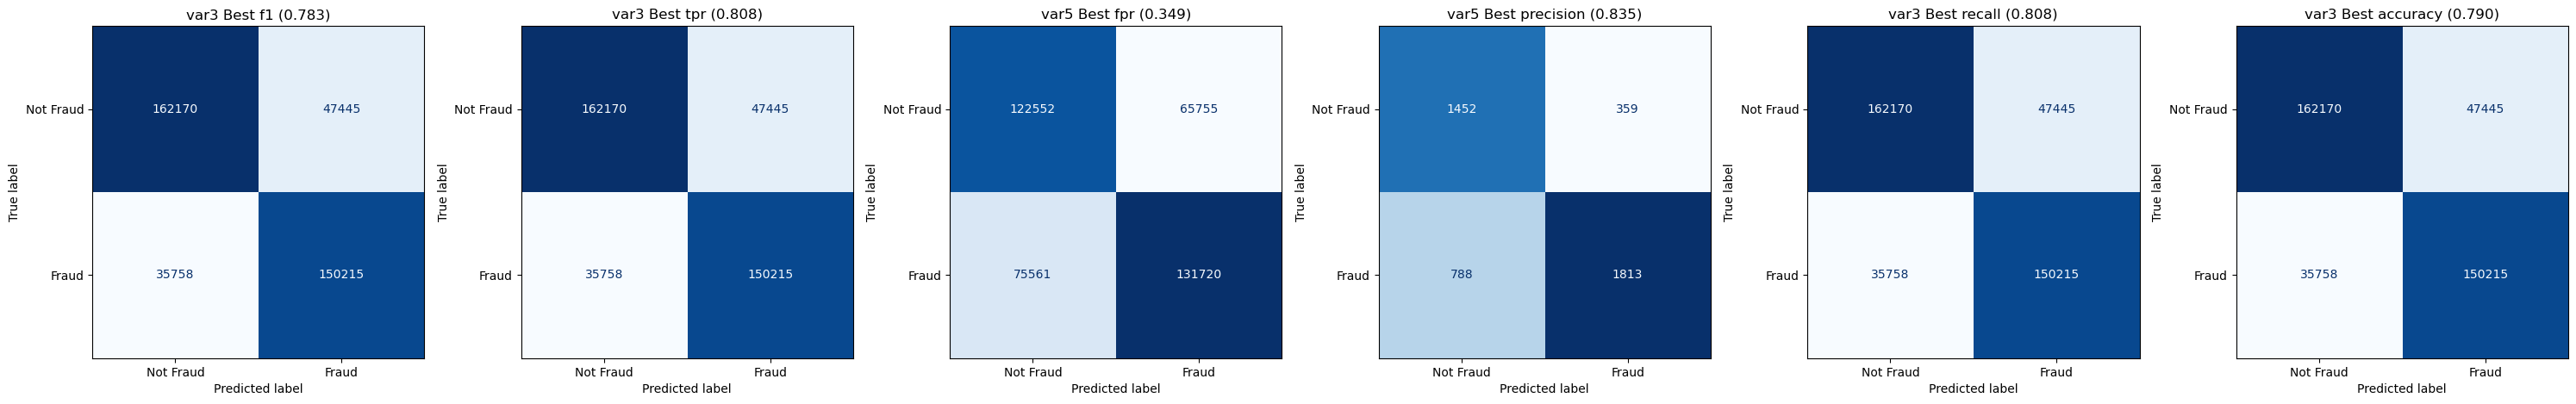

In [114]:
for num_cluster in df['num_clusters'].unique():
    curr_df = df[df['num_clusters'] == num_cluster]
    print(f"Num Cluster: {num_cluster}")
    tps, tns, fps, fns, titles = get_best_metrics(curr_df, METRICS)
    side_by_side_cms(tps, tns, fps, fns, titles)

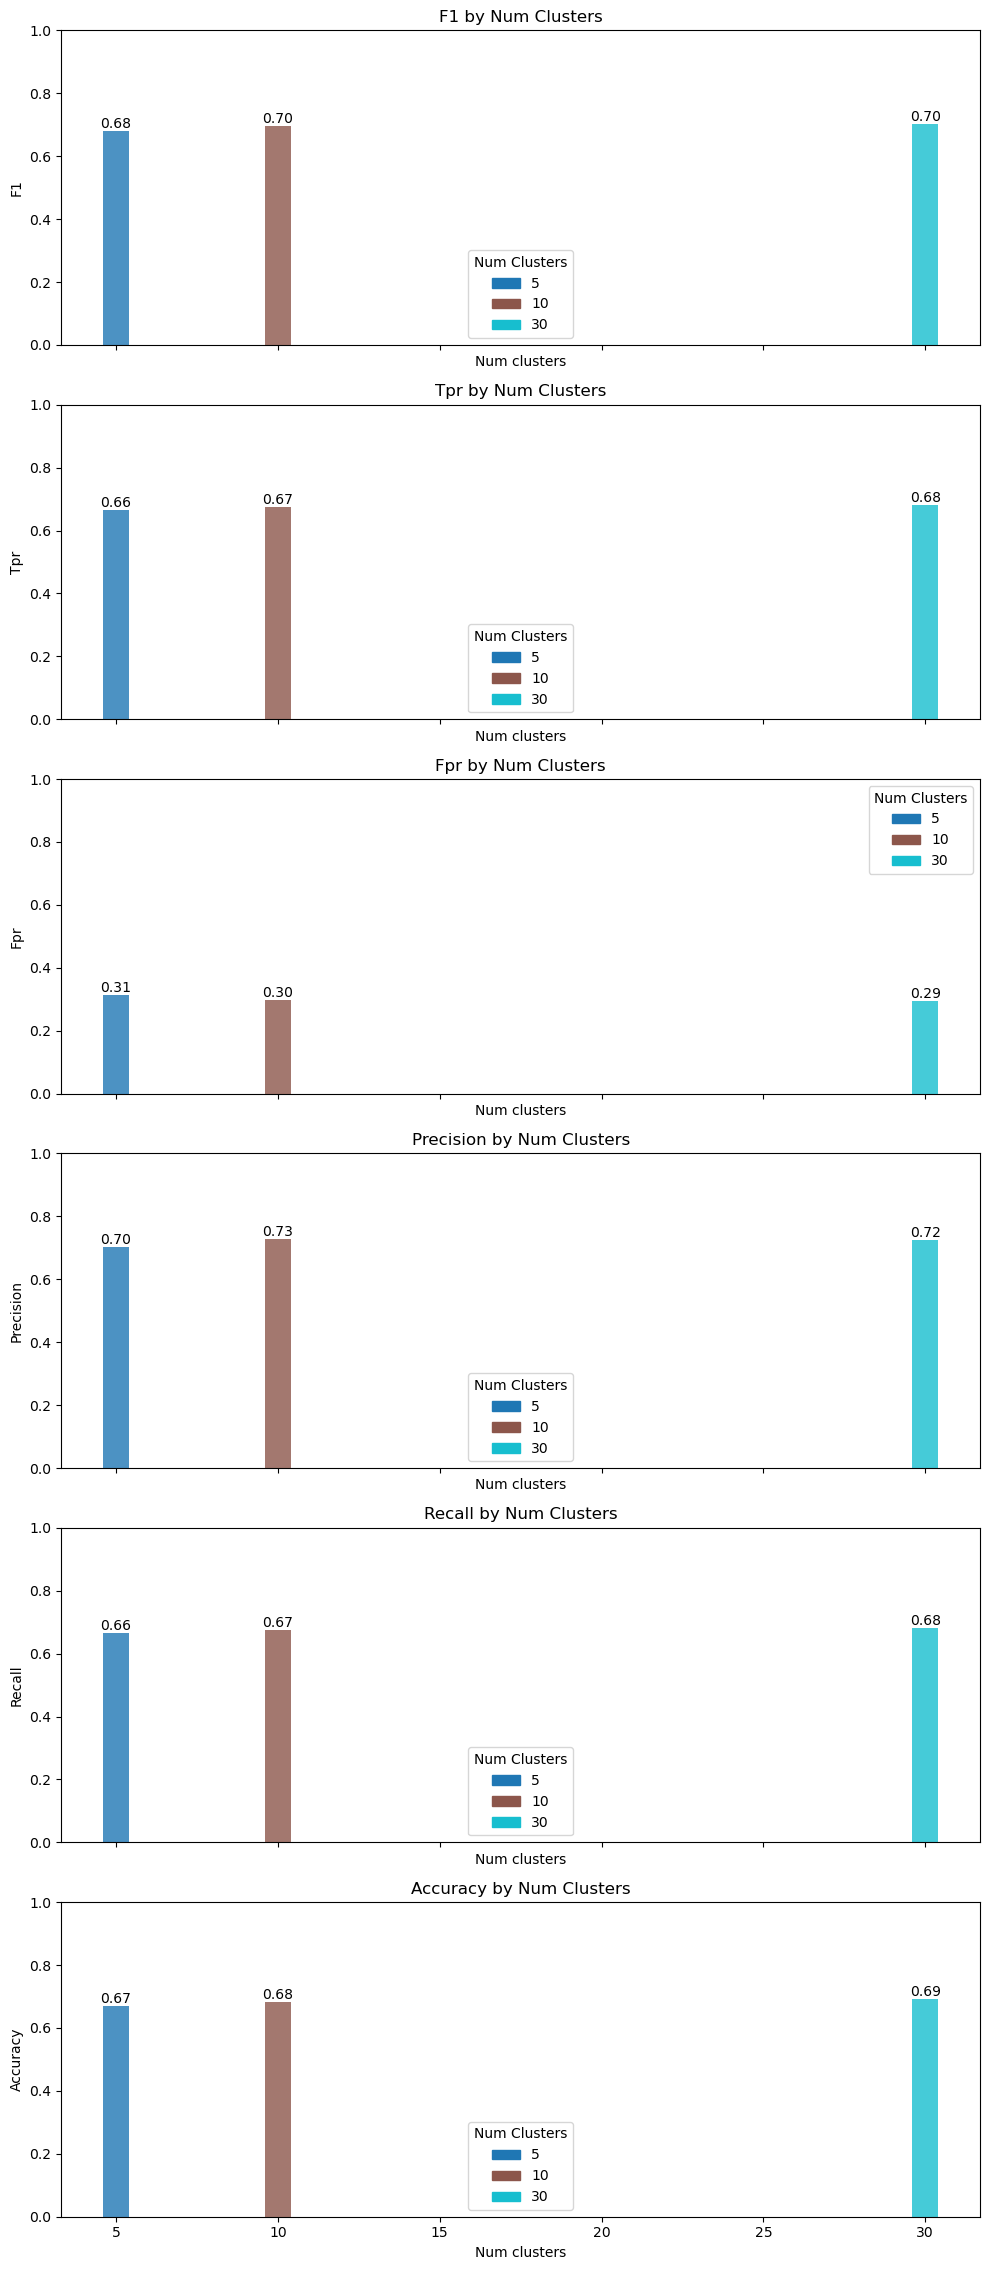

In [115]:
ncluster_avg = {k: [] for k in METRICS}

for num_cluster in df['num_clusters'].unique():
    curr_df = df[df["num_clusters"] == num_cluster]
    avg = get_avg_metrics(curr_df, METRICS)
    for metric in METRICS:
        ncluster_avg[metric].append(avg[metric])

plot_metrics_subplots(ncluster_avg, df['num_clusters'].unique(), 'Num Clusters')
        